# GraalVM vs. Standard Java for Cloud Functions

After deploying the GraalVM and Standard Java functions to Cloud Run, get their URLs.

They will look like this:

* GraalVM function: https://my-func-graalvm-2yebdnw3bq-uc.a.run.app
* Standard Java function: https://my-func-java11-2yebdnw3bq-uc.a.run.app

In [1]:
GRAAL_FN = 'my-func-graalvm'
STD_JAVA_FN = 'my-func-java11'

URLS = {
    GRAAL_FN: 'https://my-func-graalvm-2yebdnw3bq-uc.a.run.app',
    STD_JAVA_FN: 'https://my-func-java11-2yebdnw3bq-uc.a.run.app'
}

In [2]:
import random
import requests
import shlex
import subprocess
import time

def run_command(cmd_string):
    output = subprocess.check_output(shlex.split(cmd_string)).strip()
    return output.decode('utf-8')

def redeploy(container_name):
    env_code = random.randint(1, 100000)
    command = 'gcloud run services update %s ' \
        '--update-env-vars FOO=%d --platform managed --region us-central1 --max-instances 1' % (container_name, env_code)
    run_command(command)
    return env_code

def send_request(function_url, coldstart=False):
    TOKEN = run_command('gcloud auth print-identity-token')
    if coldstart and '?coldstart' not in function_url:
        function_url += '?coldstart'
    
    # Notes on time.time() precision for linux: https://stackoverflow.com/a/1938096/906497
    # On linux & mac, time precision < 1 microsecond.
    start = time.time()
    response = requests.get(function_url, headers = {'Authorization': 'Bearer %s' % TOKEN})
    end = time.time()
    
    # print(function_url + " | code: " + str(response.status_code))
    if response.status_code == 429:
        time.sleep(30)
    
    if response.status_code == 200:
        return end - start
    else:
        return send_request(function_url, coldstart)




## Cold Start Analysis

In this experiment, we measure the cold start time of the containers.

To trigger a cold start on each request, we pass the url parameter `?coldstart` in the URL.
The Java function checks for the prescence of `?coldstart` and will exit the Java process if provided. It is stopped via `System.exit()` which triggers a new instance to be created on the subsequent request:

```
if (httpRequest.getFirstQueryParameter("coldstart").isPresent()) {
      ScheduledExecutorService executorService = Executors.newScheduledThreadPool(1);
      try {
        executorService.schedule(() -> System.exit(0), 1, TimeUnit.SECONDS);
      } catch (Exception e) {
        System.err.println(e);
        System.exit(1);
      }
}
```

Also note, in the Cloud Run settings, `max_instances == 1` to ensure that only one instance is being used for the cold starts experiment.

In [3]:
import csv
import os.path
import time

def write_data(request_tuples, file_name):
    output = list(map(lambda tuple: str(tuple[0]) + "," + str(tuple[1]), request_tuples))
    with open(file_name, 'a') as file:
        file.write("\n".join(output) + "\n")

def parse_numbers(filename):
    result = []
    with open(filename, 'r') as file:
        data = csv.reader(file, delimiter=',')
        for row in data:
            result.append((int(row[0]), float(row[1])))
        
    return result

# Sequential Cold Start Requests
def sequential_cold_start_request(fn_name, file_name, times=1000):
    print("Sequential cold start tests: " + fn_name)
    for i in range(times):
        result = send_request(URLS[fn_name], True)
        print("Request %s: time = %.3f" % (fn_name, result))
        datum = (int(round(time.time() * 1000)), result)
        write_data(datum, file_name)
        time.sleep(5)

# for i in range(4):
#     sequential_cold_start_request(STD_JAVA_FN, 'std_java_coldstart_bulk.txt', 500)
#     sequential_cold_start_request(GRAAL_FN, 'graalvm_java_coldstart_bulk.txt', 500)
    

std_java_results = list(zip(*parse_numbers('std_java_coldstart_bulk.txt')))[1]
graalvm_results = list(zip(*parse_numbers('graalvm_java_coldstart_bulk.txt')))[1]

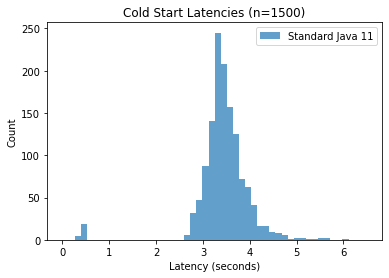

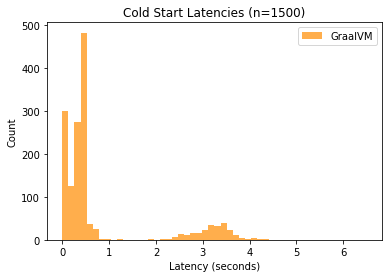

Standard Java Cold Start Latencies Percentiles
Mean = 3.448
Median (50p) = 3.426
95p = 4.173
99p = 4.852

GraalVM Cold Start Latencies Percentiles
Mean = 0.790
Median (50p) = 0.399
95p = 3.438
99p = 3.759

83.60 percent of cold starts were < 1 second.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def printStats(data, title):
    print(title)
    print('Mean = %.3f' % np.mean(data))
    print('Median (50p) = %.3f' % np.percentile(data, 50))
    print('95p = %.3f' % np.percentile(data, 95))
    print('99p = %.3f' % np.percentile(data, 99))
    print()

def plotHistogram(data, title, labels, **kwargs):
    plt.hist(data, bins=50, histtype='barstacked', label=labels, alpha=0.7, **kwargs)  # density=False would make counts
    plt.ylabel('Count')
    plt.xlabel('Latency (seconds)');
    plt.title(title)
    plt.legend()

def percentileOf(threshold, d):
    return sum(np.abs(d) < threshold) / float(len(d))
    
plotHistogram([std_java_results], 'Cold Start Latencies (n=1500)', ['Standard Java 11'], range=(0,6.5))
plt.show()
plotHistogram([graalvm_results], 'Cold Start Latencies (n=1500)', ['GraalVM'], range=(0,6.5), color='darkorange')
plt.show()

printStats(std_java_results, 'Standard Java Cold Start Latencies Percentiles')
printStats(graalvm_results, 'GraalVM Cold Start Latencies Percentiles')

graal_slow_percentile = percentileOf(2, graalvm_results) * 100
print('%.2f percent of cold starts were < 1 second.' % graal_slow_percentile)

## Sequential Warm Requests Experiment

Send requests sequentially to warmed Cloud Run instance.

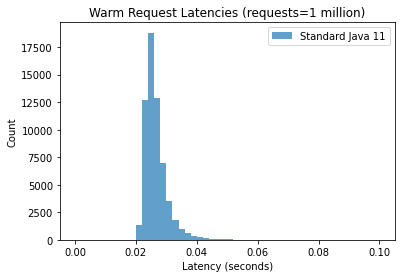

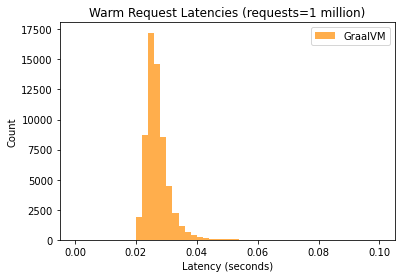

Std. Java Warm Latencies
Mean = 0.027
Median (50p) = 0.026
95p = 0.034
99p = 0.042

GraalVM Warm Latencies
Mean = 0.028
Median (50p) = 0.026
95p = 0.034
99p = 0.044



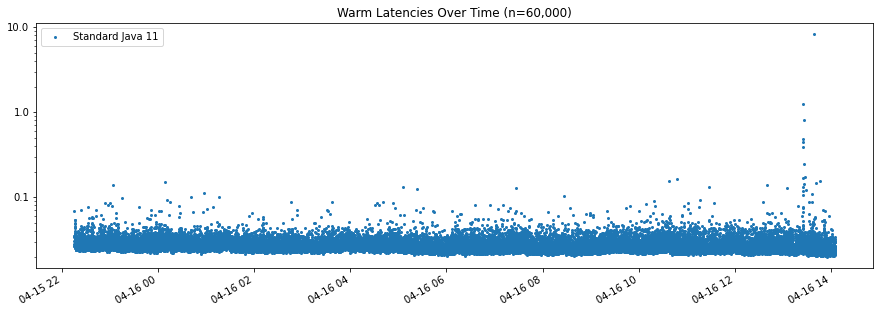

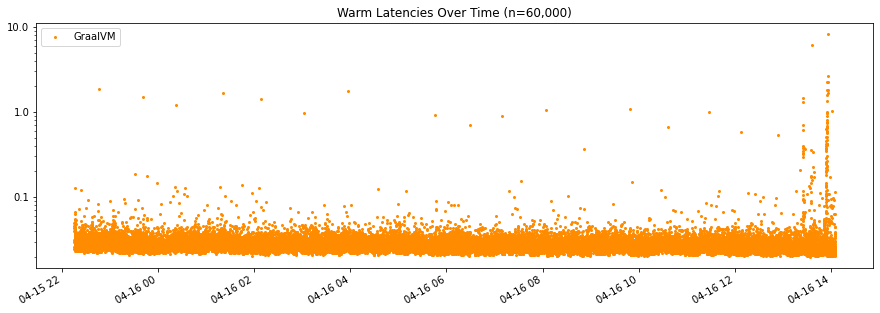

In [34]:
from datetime import datetime
from matplotlib.ticker import ScalarFormatter

def sequential_request(fn_name, file_name, times=10):
    write_result = []
    for i in range(times):
        result = send_request(URLS[fn_name], False)
        datum = (int(round(time.time())), result)
        write_result.append(datum)
        # print("Request %s: time = %.3f" % (fn_name, result))    
    write_data(write_result, file_name)


# for i in range(200000):
#     sequential_request(STD_JAVA_FN, 'std_java_warm_requests_bulk.txt', times=1)
#     sequential_request(GRAAL_FN, 'graalvm_warm_requests_bulk.txt', times=1)
#     if i % 100 == 0: 
#         print("iters: " + str(i))

std_java_ts = list(zip(*parse_numbers('std_java_warm_requests_bulk.txt')))[0]
std_java_ts = list(map(lambda x: datetime.fromtimestamp(x), std_java_ts))
std_java_warm = list(zip(*parse_numbers('std_java_warm_requests_bulk.txt')))[1]

graalvm_ts = list(zip(*parse_numbers('graalvm_warm_requests_bulk.txt')))[0]
graalvm_ts = list(map(lambda x: datetime.fromtimestamp(x), graalvm_ts))
graalvm_warm = list(zip(*parse_numbers('graalvm_warm_requests_bulk.txt')))[1]

plotHistogram([std_java_warm], 'Warm Request Latencies (requests=60k)', ['Standard Java 11'], range=(0, 0.1))
plt.show()
plotHistogram([graalvm_warm], 'Warm Request Latencies (requests=60k)', ['GraalVM'], range=(0, 0.1), color='darkorange')
plt.show()

printStats(std_java_warm, 'Std. Java Warm Latencies')
printStats(graalvm_warm, 'GraalVM Warm Latencies')

def plot_scatter(x, y, **kwargs):
    
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ScalarFormatter())
    
    plt.scatter(x, y, s=4, **kwargs)
    plt.title('Warm Latencies Over Time (n=60,000)')
    plt.legend()

plot_scatter(std_java_ts, std_java_warm, label='Standard Java 11')
plot_scatter(graalvm_ts, graalvm_warm, color='darkorange', label='GraalVM')


In [ ]:
# Busy loop
# for i in range(90000):
#     TOKEN = run_command('gcloud auth print-identity-token')
#     send_request(URLS[GRAAL_FN], False)
#     send_request(URLS[STD_JAVA_FN], False)
#     time.sleep(1)